# ``graspologic`` demo

## Background

``graspologic`` is a Python package for doing statistical/machine learning analyses on 
network data.

Some historical background: ``graspologic`` started as two separate packages, one 
developed by the NeuroData lab, and one by a group at Microsoft Research. A couple years
ago, we decided to merge the two (which had a fair bit of overlapping functionality).

We've tried to give the package an API similar to that of scikit-learn or SciPy, where
appropriate. In a few places this falls apart a bit for historical reasons (see above),
so if there's anything that is annoying in that respect for your purposes, please let
us know. 

In [34]:
!pip install graspologic --pre

In [35]:
import graspologic

graspologic.__version__

'3.0.0.dev4997377482'

## Loading some data

In [36]:
import pandas as pd

edges = pd.read_csv(
    "https://raw.githubusercontent.com/neurodata/neuropull/main/data/maggot_brain/edgelist.csv.gz"
)
edges[["source", "target", "weight"]]

,source,target,weight
0,29,2506050,1
1,29,3347834,4
2,29,3522293,4
3,29,3886356,3
4,29,3890028,1
...,...,...,...
110672,21591317,17729088,4
110673,21591317,17777259,1
110674,21591317,20278329,1
110675,21591317,20443420,1


In [37]:
nodes = pd.read_csv(
    "https://raw.githubusercontent.com/neurodata/neuropull/main/data/maggot_brain/nodes.csv.gz",
    index_col=0,
)
nodes[["side", "pair"]]

,side,pair
node_id,,
2206279,left,2
2216445,left,5
2215247,left,7
10241716,left,8
2216131,left,11
...,...,...
8978117,right,1641
8957325,right,1642
6978516,right,1643


In [38]:
def edges_to_adjacency(edges, source_index, target_index=None):
    if target_index is None:
        target_index = source_index
    adjacency = (
        pd.crosstab(edges["source"], edges["target"], edges["weight"], aggfunc="sum")
        .reindex(index=source_index, columns=target_index)
        .fillna(0)
    )
    adjacency.index.name = "source"
    adjacency.columns.name = "target"
    return adjacency


adjacency = edges_to_adjacency(edges, nodes.index).values
adjacency

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(<Axes: >, <mpl_toolkits.axes_grid1.axes_divider.AxesDivider at 0x13aecc2e0>)

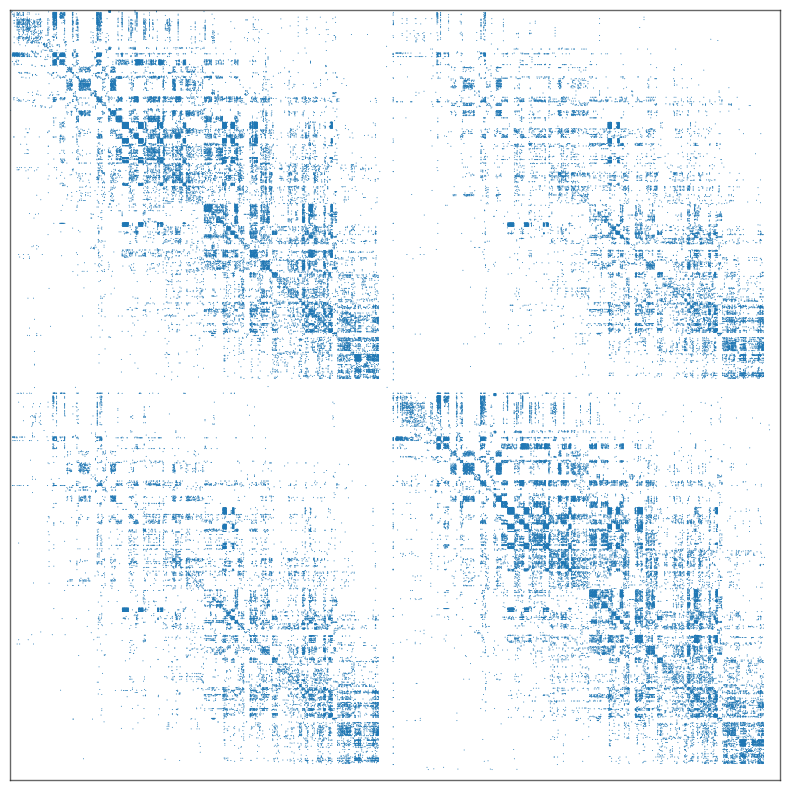

In [39]:
from graspologic.plot import adjplot

adjplot(adjacency, plot_type="scattermap", sizes=(0.5, 0.5))

## Network embedding

Generally speaking, an **embedding** refers to some technique which takes a network (or
networks as we'll see later) and converts it to a representation in some vector space.
Often, this is a Euclidean vector space, and in that space each vector represents a
single node in the network. We'll focus on this case for now.

### Why embed networks? 
- Embeddings can be useful for creating visualizations of networks. 
- Embeddings allow us to use a wide range of general machine learning techniques and
  make them applicable for networks.
- Embedding networks can be viewed as fitting the parameters of statistical models, 
  for example, a random dot product graph.

In `graspologic`, this functionality is implemented under the `AdjacencySpectralEmbed` 
estimator class. There are a few extra bells and whistles, but the core algorithm is
exactly the same as the one above - just an SVD of the adjacency matrix. Note that this
algorithm also works well for weighted networks, but we lose some of the interpretation
of the approximation matrix as a matrix of probabilities.

In [40]:
from graspologic.embed import AdjacencySpectralEmbed

ase = AdjacencySpectralEmbed()

X, Y = ase.fit_transform(adjacency)

/Users/bpedigo/JHU_code/graspologic-demo/.venv/lib/python3.10/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


The warning above arises because there are some nodes in the network which don't connect to the bulk. This tends to distort many embedding (and other) algorithms. Thankfully, it is easy to identify and remove these nodes from the network.

In [41]:
from graspologic.utils import largest_connected_component

adjacency_lcc, lcc_indices = largest_connected_component(adjacency, return_inds=True)
nodes_lcc = nodes.iloc[lcc_indices]

X, Y = ase.fit_transform(adjacency_lcc)

`ase.fit_transform()` returns a tuple `(X, Y)` if the graph is directed. Otherwise, it
just returns `X`.

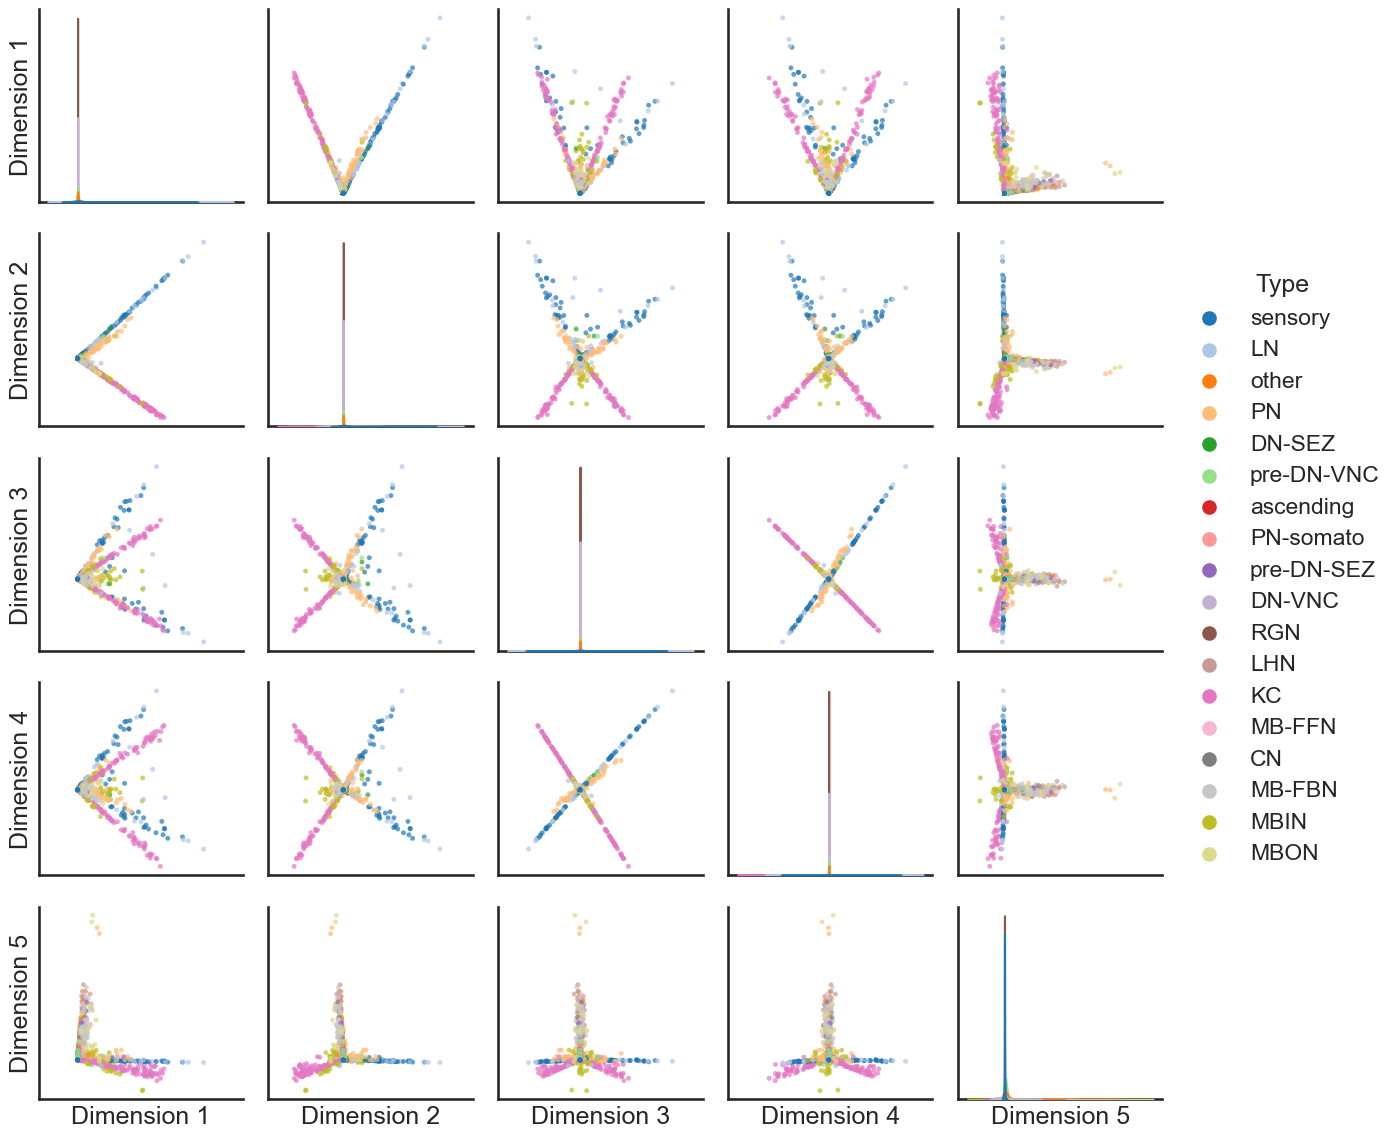

In [42]:
from graspologic.plot import pairplot

labels = nodes_lcc["super_class"].values
pairplot(X, labels=labels, palette="tab20")

For spectral methods on weighted networks, we often find it useful to do an operation 
called "pass-to-ranks." This essentially ranks each edge from smallest to largest weight,
then replaces the edge weight by a normalized version of the rank. It has the effect of
putting edges closer to the same scale.

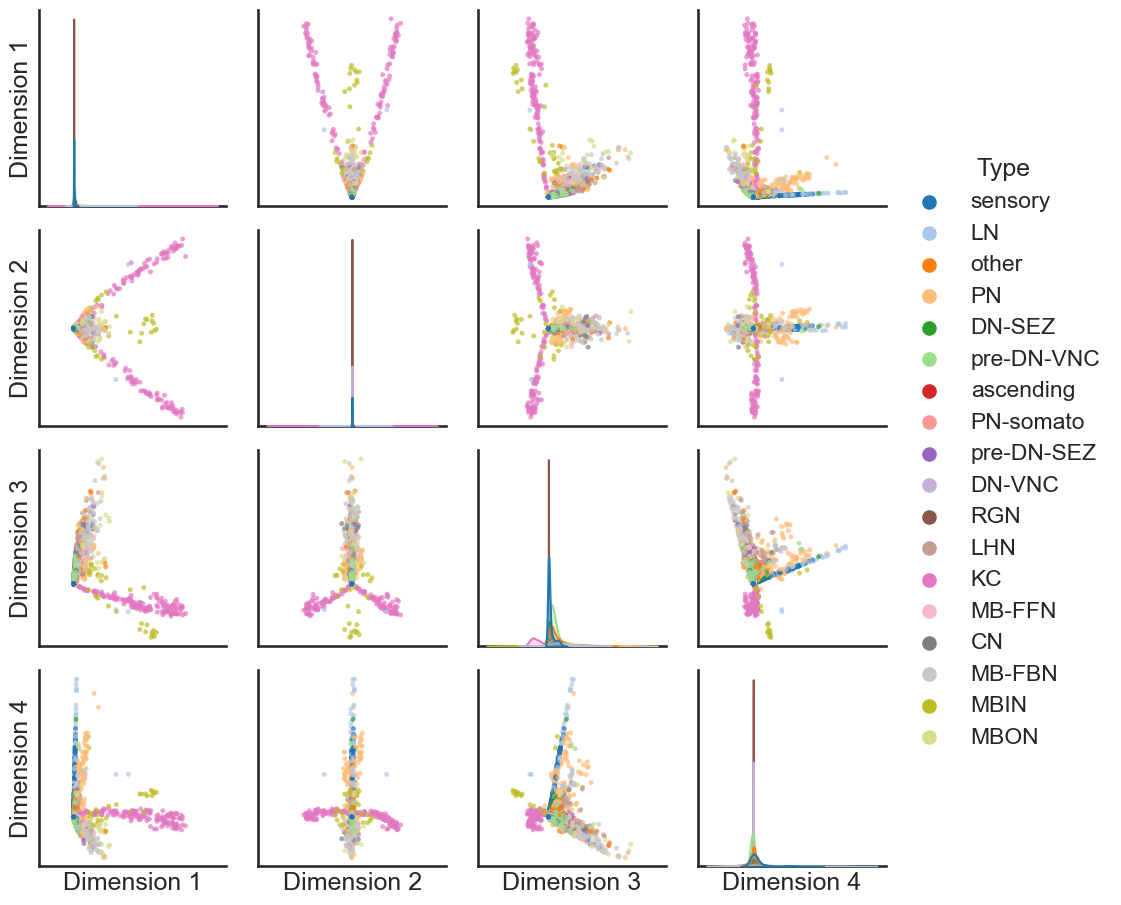

In [43]:
from graspologic.utils import pass_to_ranks

ase = AdjacencySpectralEmbed()

adjacency_ptr = pass_to_ranks(adjacency_lcc)

X, Y = ase.fit_transform(adjacency_ptr)

pairplot(X, labels=labels, palette="tab20")

For some applications, we don't care about having a separate representation for each 
node in terms of its inputs and outputs. We can simply concatenate the "out" and "in" 
representations. You can do this yourself, or we can specify this behavior in `graspologic`.

In [44]:
Z = AdjacencySpectralEmbed(concat=True).fit_transform(adjacency_lcc)
Z.shape

(2952, 10)

We can also embed a matrix in sparse format, which will usually be faster for sparse 
networks with more than a small number of nodes.

In [46]:
from scipy.sparse import csr_array

Z = AdjacencySpectralEmbed(concat=True).fit_transform(csr_array(adjacency_lcc))
Z.shape

(2952, 10)

## Network models

``graspologic`` contains functionality for fitting and sampling from several network 
statistical models. For instance, a [**stochastic block model (SBM)**
](https://en.wikipedia.org/wiki/Stochastic_block_model)
is a popular statistical model of networks. Put simply, this model treats the
probability of an edge occurring between node $i$ and node $j$ as purely a function of
the *communities* or *groups* that node $i$ and $j$ belong to. Therefore, this model
is parameterized by:

   1. An assignment of each node in the network to a group. Note that this assignment
      can be considered to be deterministic or random, depending on the specific
      framing of the model one wants to use.
   2. A set of group-to-group connection probabilities



<div class="alert alert-block alert-info">
<b>Tip:</b> Use blue boxes (alert-info) for tips and notes.</div>



<div class="alert alert-block alert-info">
<b>Details:</b> 
Let $n$ be the number of nodes, and $K$ be the number of groups in an SBM. For a
network $A$ sampled from an SBM: $$ A \sim SBM(B, \tau)$$ We say that for all $(i,j), i \neq j$, with $i$ and $j$ both running
from $1 ... n$ the probability of edge $(i,j)$ occurring is: $$ P[A_{ij} = 1] = P_{ij} = B_{\tau_i, \tau_j} $$
where $B \in [0,1]^{K \times K}$ is a matrix of group-to-group connection
probabilities and $\tau \in \{1...K\}^n$ is a vector of node-to-group assignments.
Note that here we are assuming $\tau$ is a fixed vector of assignments, though other
formulations of the SBM allow these assignments to themselves come from a categorical
distribution.</div>





In [303]:
from graspologic.models import SBMEstimator

estimator = SBMEstimator(directed=True, loops=True)

In [48]:
from graspologic.utils import binarize

estimator.fit(binarize(adjacency_lcc), y=labels)

SBMEstimator(loops=True)

<Axes: >

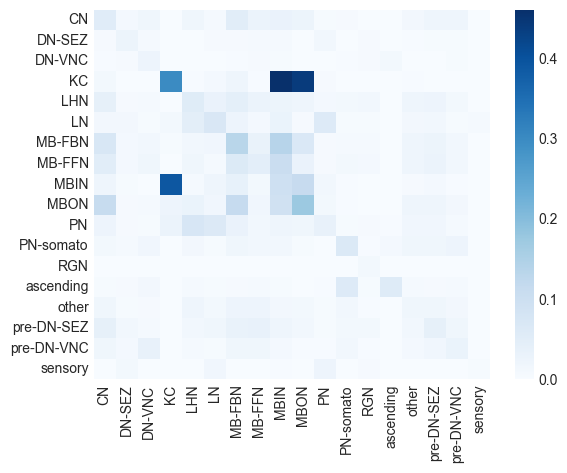

In [49]:
import numpy as np
import seaborn as sns

block_probabilities = pd.DataFrame(
    estimator.block_p_, index=np.unique(labels), columns=np.unique(labels)
)

sns.heatmap(block_probabilities, cmap="Blues")

(<Axes: >, <mpl_toolkits.axes_grid1.axes_divider.AxesDivider at 0x14363a5f0>)

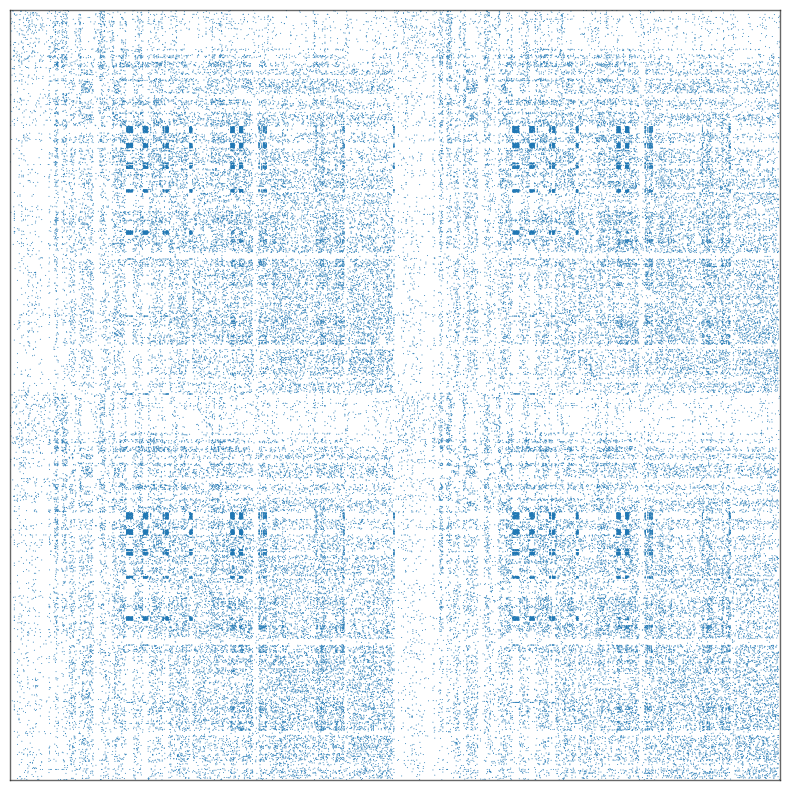

In [50]:
# sampled_adjacency = estimator.sample()[0]

# adjplot(sampled_adjacency, plot_type="scattermap", sizes=(0.5, 0.5))

In [100]:
left_nodes = nodes_lcc.query("side == 'left'")
right_nodes = nodes_lcc.query("side == 'right'")

left_adjacency = edges_to_adjacency(edges, left_nodes.index, left_nodes.index).values
right_adjacency = edges_to_adjacency(edges, right_nodes.index, right_nodes.index).values

left_labels = left_nodes["super_class"].values
right_labels = right_nodes["super_class"].values

In [101]:
from graspologic.inference import group_connection_test

stat, pvalue, misc = group_connection_test(
    left_adjacency, right_adjacency, left_labels, right_labels
)

print(f"p-value: {pvalue:.3g}")

/Users/bpedigo/JHU_code/graspologic-demo/.venv/lib/python3.10/site-packages/graspologic/inference/group_connection_test.py:369: UserWarning: This test assumes that the networks are unweighted, but one or both adjacency matrices are weighted.Test will be run on the binarized version of these adjacency matrices.
  warnings.warn(msg)
/Users/bpedigo/JHU_code/graspologic-demo/.venv/lib/python3.10/site-packages/graspologic/inference/group_connection_test.py:376: UserWarning: This test assumes that the networks are loopless, but one or both adjacency matrices have self-loops.Test will be run on the loopless version of these adjacency matrices.
  warnings.warn(msg)


p-value: 0.000565


In [102]:
misc["corrected_pvalues"]

target,CN,DN-SEZ,DN-VNC,KC,LHN,LN,MB-FBN,MB-FFN,MBIN,MBON,PN,PN-somato,RGN,ascending,other,pre-DN-SEZ,pre-DN-VNC,sensory
source,,,,,,,,,,,,,,,,,,
CN,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.00000,NaN
DN-SEZ,1.000000,1.0,1.0,NaN,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.00000,1.0
DN-VNC,1.000000,1.0,1.0,NaN,1.000000,1.0,1.000000,1.0,1.0,NaN,1.0,1.000000,1.0,1.0,1.000000,1.0,1.00000,1.0
KC,0.155539,1.0,NaN,0.021503,1.000000,1.0,0.097526,1.0,1.0,0.859585,1.0,1.000000,NaN,NaN,1.000000,1.0,1.00000,NaN
LHN,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,0.295510,1.0,1.00000,NaN
LN,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,NaN,0.771082,1.0,1.00000,1.0
MB-FBN,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,NaN,1.000000,1.0,1.00000,NaN
MB-FFN,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,NaN,1.000000,1.0,1.00000,NaN
MBIN,1.000000,NaN,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,NaN,NaN,1.000000,1.0,1.00000,NaN


<Axes: xlabel='target', ylabel='source'>

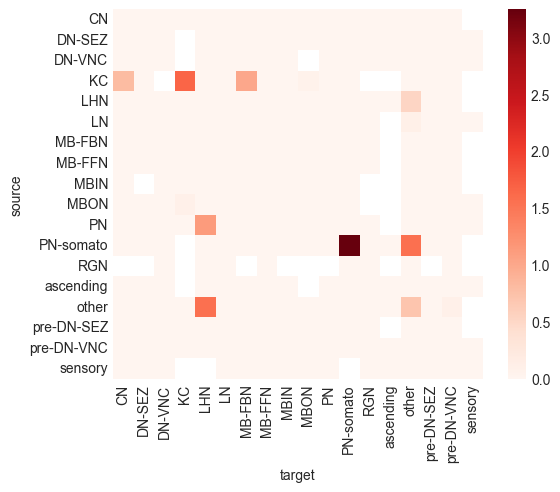

In [103]:
sns.heatmap(-np.log10(misc["corrected_pvalues"]), square=True, cmap="Reds")

## Graph matching

To start to understand graph matching, we first need to understand permutations and 
permutation matrices.

A [**permutation**](https://en.wikipedia.org/wiki/Permutation) can be thought of as a
specific ordering or arrangement of some number of objects. 

How many permutations are there of $n$ objects?


Permutations, for us, will be represented by [**permutation matrices**](https://en.wikipedia.org/wiki/Permutation_matrix).
A permutation matrix is $n \times n$, with all zeros except for $n$ 1s. More specifically, each row and column has exactly one 1 in it. Let's look at
what a permutation matrix times a vector looks like.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Permutation_matrix%3B_P_%2A_column.svg" width="200"/>
</div>

A permutation matrix multiplied by a vector. The red elements of the matrix indicate the 
1s. Image from [Wikipedia](https://en.wikipedia.org/wiki/Permutation_matrix).


So, we see that if we look at the permutation matrix, the *row index* represents the 
index of the new position of object $i$. The *column index* represents the original
position of an object. So, if we have a 1 at position $(1, 4)$, that means the first
object was the fourth object in the original arangement.

Note that this also works for matrices: each column of a matrix $A$ would be permuted
the same way as the vector in the example above. So, we can think of 

$$PA$$

as permuting the *rows* of the matrix $A$.

Note that post-multiplication by the matrix $P$ works the opposite way (try it out 
yourself if you don't see this, or refer to the Wikipedia article). For this reason, if
we wanted to permute the columns of $A$ in the same way, we'd have to do

$$AP^T$$

```{admonition} Question
:class: tip

How can we permute the rows *and* columns of the matrix $A$ in the same way? Why do 
we care about this for networks?
```

## Graph matching problem

Why do we care about permutations for the problem of [**graph matching**](https://en.wikipedia.org/wiki/Graph_matching)?
Graph matching refers to the problem of finding a mapping between the nodes of one graph ($A$)
and the nodes of some other graph, $B$. For now, consider the case where the two networks
have exactly the same number of nodes. Then, this problem amounts to finding a *permutation* 
of the nodes of one network with regard to the nodes of the other. Mathematically, we
can think of this as comparing $A$ vs. $P B P^T$. 

How can we measure the quality of this alignment between two networks? One natural way to do this is via the Frobenius norm of the difference. 

$$e(P) = \|A - PBP^T\|_F$$

```{admonition} Question
:class: tip

In words, what is this quantity $e(P)$ measuring with respect to the edges of two
unweighted networks?
```

We can use this same definition above for any type of network: unweighted or weighted, 
directed or undirected, with or without self-loops.

```{figure} ./images/network-matching-explanation.png
Diagram explaining graph matching.
```

## Solving the graph matching problem

If you are curious...

Many solutions for the problem above have been proposed - note that all of these are 
approximate solutions, and they tend to scale fairly poorly (in the number of nodes)
compared to some of the other algorithms we have discussed so far. Nevertheless, a lot 
of progress has been made. I'm just going to focus on one family of algorithms based
on the work of {cite:t}`vogelstein2015fast`.

As we discussed when looking at the spectral method for maximizing modularity, we have a
discrete problem, but we'd like to use continuous optimization tools where we can take
gradients. To make this possible, the Fast Approximate Quadradic (FAQ) method first 
relaxes the constraint that $P$ be a permutation matrix. Via the Birkhoff-von Neumann theorem, it can be shown that the [convex hull](https://en.wikipedia.org/wiki/Convex_hull)
of the permutation matrices is the set of [**doubly stochastic matrices**](https://en.wikipedia.org/wiki/Doubly_stochastic_matrix). A doubly stochastic matrix just has row 
and columns sums equal to 1, but does not necessarily have to have all nonzero elements
equal to 1. This theorem is just saying that if I take a weighted average of any two 
permutation matrices, the row and columns sums of the result must be 1.

It can be shown that minimizing our $e(P)$ above is equivalent to 

$$\min_P -\text{trace}(APB^T P^T)$$

```{note}
The [**quadratic assignment problem**](https://en.wikipedia.org/wiki/Quadratic_assignment_problem) can be written as $\min_P \text{trace}(APB^T P^T)$ - since these are just a sign flip away, any algorithm which solves one can be
easily used to solve the other.
```

Calling our doubly stochastic matrices $D$, we now have 

$$\min_D -\text{trace}(ADB^T D^T)$$

Given this relaxation, we can now begin to take gradients in our space of matrices. I won't go into every detail, but the algorithm we end up using is 
something like:
1. Start with some initial position - note that this position is a doubly stochastic matrix.
2. Compute the gradient of the expression above with respect to $D$. This gives us our "step direction."
3. Compute a step size (how far to go in that direction in the space of matrices) by searching over the line between our current position and the one computed in 2.
4. Update our position based on 3.
5. Repeat 2.-4. until some convergence criterion is reached.
6. Project back to the set of permutation matrices.

## Graph matching with `graspologic`

### Basic graph matching

Thankfully, all of this is implemented in `graspologic`. Let's start by generating a random network (ER). We'll then make a permuted copy of itself.

In [104]:
from graspologic.match import graph_match
from graspologic.simulations import er_np

n = 20
p = 0.3

np.random.seed(1)
rng = np.random.default_rng(8888)

G1 = er_np(n=n, p=p)

node_shuffle_input = np.random.permutation(n)
G2 = G1[node_shuffle_input][:, node_shuffle_input]

print("Number of edge disagreements: ", np.sum(abs(G1 - G2)))

Number of edge disagreements:  168.0


<Axes: title={'center': 'Difference'}>

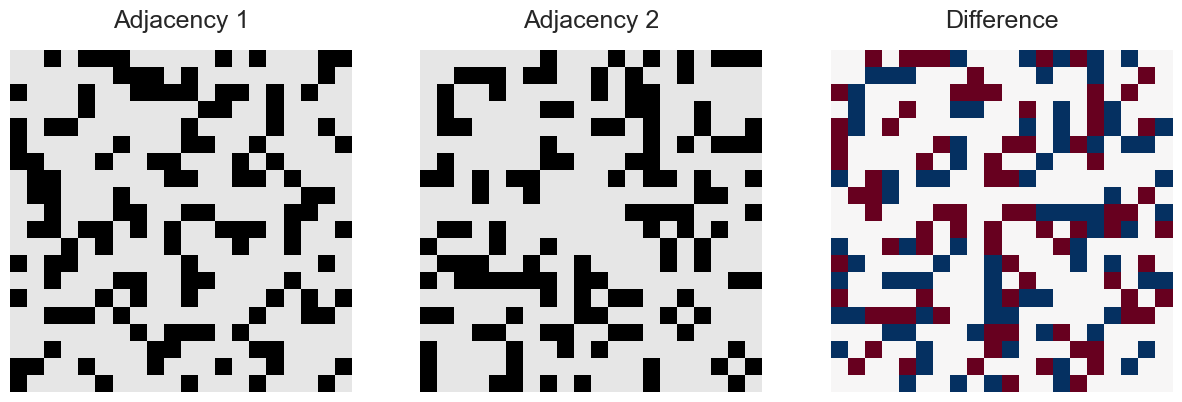

In [105]:
import matplotlib.pyplot as plt
from graspologic.plot import heatmap

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
heatmap(
    G1,
    cbar=False,
    title="Adjacency 1",
    ax=axs[0],
    cmap="binary",
    vmin=0.1,
    center=0.5,
    vmax=1,
)
heatmap(
    G2,
    cbar=False,
    title="Adjacency 2",
    ax=axs[1],
    cmap="binary",
    vmin=0.1,
    center=0.5,
    vmax=1,
)
heatmap(G1 - G2, cbar=False, title="Difference", ax=axs[2], center=0, vmin=-1, vmax=1)

Now, let's solve the graph matching problem.

In [106]:
_, perm_inds, _, _ = graph_match(G1, G2, rng=rng)
G2 = G2[perm_inds][:, perm_inds]
print("Number of edge disagreements: ", np.sum(abs(G1 - G2)))

Number of edge disagreements:  0.0


So, we've exactly recovered the correct permutation - note that this won't always be true.

## Apply to some connectome data

In [109]:
left_permutation, right_permutation, score, misc = graph_match(
    left_adjacency, right_adjacency, rng=rng, verbose=3
)

[Pre-loop] Initializing
   [Pre-loop] Computing constant terms
   [Iteration: 1] Computing gradient
   [Iteration: 1] Solving assignment problem
   [Iteration: 1] Computing step size
   [Iteration: 2] Computing gradient
   [Iteration: 2] Solving assignment problem
   [Iteration: 2] Computing step size
   [Iteration: 3] Computing gradient
   [Iteration: 3] Solving assignment problem
   [Iteration: 3] Computing step size
   [Iteration: 4] Computing gradient
   [Iteration: 4] Solving assignment problem
   [Iteration: 4] Computing step size
   [Iteration: 5] Computing gradient
   [Iteration: 5] Solving assignment problem
   [Iteration: 5] Computing step size
   [Iteration: 6] Computing gradient
   [Iteration: 6] Solving assignment problem
   [Iteration: 6] Computing step size
   [Iteration: 7] Computing gradient
   [Iteration: 7] Solving assignment problem
   [Iteration: 7] Computing step size
   [Iteration: 8] Computing gradient
   [Iteration: 8] Solving assignment problem
   [Iteration: 

<Axes: title={'center': 'Difference'}>

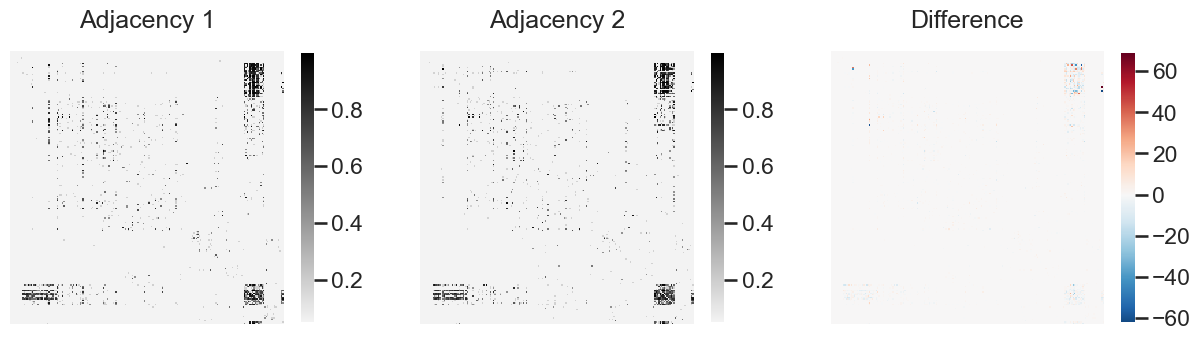

In [110]:
left_adjacency_permuted = left_adjacency[left_permutation][:, left_permutation]
right_adjacency_permuted = right_adjacency[right_permutation][:, right_permutation]

show_nodes = slice(0, 200)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

heatmap(
    left_adjacency_permuted[show_nodes][:, show_nodes],
    title="Adjacency 1",
    transform="simple-nonzero",
    ax=axs[0],
    cmap="binary",
    vmin=0.05,
    center=0.5,
)
heatmap(
    right_adjacency_permuted[show_nodes][:, show_nodes],
    title="Adjacency 2",
    transform="simple-nonzero",
    ax=axs[1],
    cmap="binary",
    vmin=0.05,
    center=0.5,
)
heatmap(
    left_adjacency_permuted[show_nodes][:, show_nodes]
    - right_adjacency_permuted[show_nodes][:, show_nodes],
    title="Difference",
    ax=axs[2],
    cmap="RdBu_r",
)

In [113]:
score

1004556.0

In [114]:
misc[0]

{'score': 1004556.0,
 'n_iter': 30,
 'convex_solution': array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'converged': False}

## Putting it all together

In [151]:
left_pn_nodes = left_nodes.query("(super_class == 'PN') & has_valid_pair")
right_pn_nodes = right_nodes.query("super_class == 'PN' & has_valid_pair")
left_kc_nodes = left_nodes.query("super_class == 'KC'").sample(frac=1)
right_kc_nodes = right_nodes.query("super_class == 'KC'").sample(frac=1)

In [152]:
left_pn_nodes = left_pn_nodes.sort_values("pair")
right_pn_nodes = right_pn_nodes.sort_values("pair")

assert (left_pn_nodes["pair"].values == right_pn_nodes["pair"].values).all()

In [153]:
partial_match = np.stack(
    (np.arange(len(left_pn_nodes)), np.arange(len(right_pn_nodes)))
).T
partial_match.shape

(103, 2)

In [154]:
left_index = np.concatenate((left_pn_nodes.index, left_kc_nodes.index))
right_index = np.concatenate((right_pn_nodes.index, right_kc_nodes.index))

left_subgraph_adjacency = edges_to_adjacency(edges, left_index, left_index).values
right_subgraph_adjacency = edges_to_adjacency(edges, right_index, right_index).values

<Axes: >

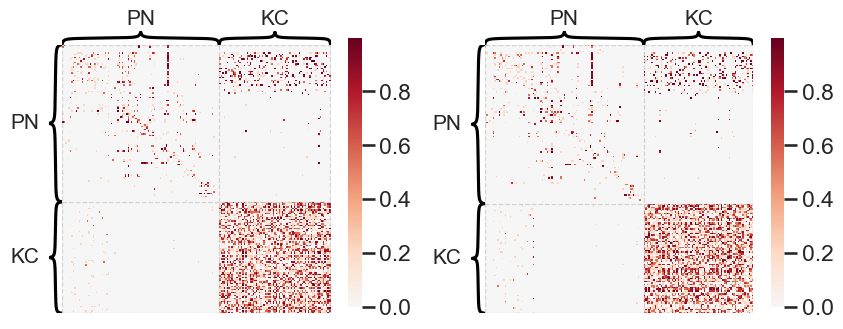

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

left_labels = left_nodes.loc[left_index, "super_class"].values
right_labels = right_nodes.loc[right_index, "super_class"].values

heatmap(
    left_subgraph_adjacency,
    transform="simple-nonzero",
    inner_hier_labels=left_labels,
    hier_label_fontsize=15,
    ax=axs[0],
)
heatmap(
    right_subgraph_adjacency,
    transform="simple-nonzero",
    inner_hier_labels=right_labels,
    hier_label_fontsize=15,
    ax=axs[1],
)

In [156]:
left_permutation, right_permutation, score, misc = graph_match(
    left_subgraph_adjacency, right_subgraph_adjacency, partial_match=partial_match
)
score

56141.0

<Axes: >

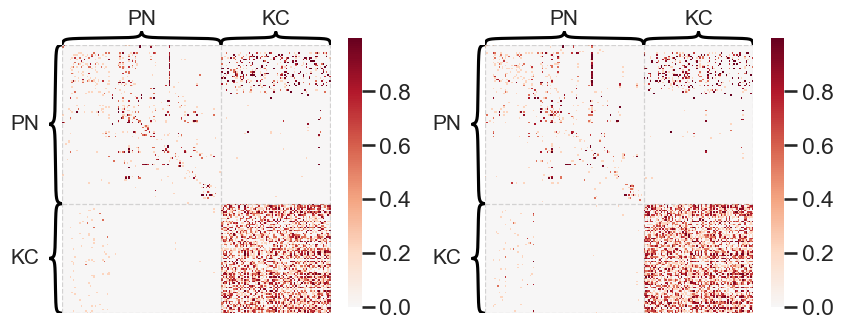

In [157]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

heatmap(
    left_subgraph_adjacency[left_permutation][:, left_permutation],
    transform="simple-nonzero",
    inner_hier_labels=left_labels[left_permutation],
    hier_label_fontsize=15,
    ax=axs[0],
)
heatmap(
    right_subgraph_adjacency[right_permutation][:, right_permutation],
    transform="simple-nonzero",
    inner_hier_labels=right_labels[right_permutation],
    hier_label_fontsize=15,
    ax=axs[1],
)

In [260]:
nodes["super_class"].value_counts()

super_class
pre-DN-VNC    478
sensory       434
other         374
KC            222
PN            206
LHN           202
DN-VNC        182
DN-SEZ        164
PN-somato     152
LN            110
MB-FBN        108
pre-DN-SEZ    102
CN            100
RGN            54
MB-FFN         54
MBON           48
ascending      46
MBIN           30
Name: count, dtype: int64

In [297]:
# left_index = left_kc_nodes.index
# right_index = right_kc_nodes.index

left_index = left_nodes.query("super_class == 'KC'").index
right_index = right_nodes.query("super_class == 'KC'").index

left_subgraph_adjacency = edges_to_adjacency(edges, left_index, left_index).values
right_subgraph_adjacency = edges_to_adjacency(edges, right_index, right_index).values

# left_subgraph_adjacency[left_subgraph_adjacency <= 2] = 0
# right_subgraph_adjacency[right_subgraph_adjacency <= 2] = 0

In [298]:
_, _, obs_score, _ = graph_match(left_subgraph_adjacency, right_subgraph_adjacency)
print(obs_score)

25805.0


In [299]:
from graspologic.models import DCEREstimator

left_estimator = DCEREstimator(directed=True, loops=True)
right_estimator = DCEREstimator(directed=True, loops=True)

left_estimator.fit(binarize(left_subgraph_adjacency))
right_estimator.fit(binarize(right_subgraph_adjacency))

print(left_estimator.p_)
print(right_estimator.p_)

3075.0
3098.0


In [300]:
def get_edge_weights(adjacency):
    row_indices, col_indices = np.nonzero(adjacency)
    edge_weights = adjacency[row_indices, col_indices]
    return edge_weights


def sample_weighted_network(estimator, edge_weights):
    sampled_adjacency = estimator.sample()[0]
    row_inds, col_inds = np.nonzero(sampled_adjacency)
    samlped_weights = rng.choice(edge_weights, size=len(row_inds), replace=True)
    sampled_adjacency[row_inds, col_inds] = samlped_weights
    return sampled_adjacency


left_edge_weights = get_edge_weights(left_subgraph_adjacency)
right_edge_weights = get_edge_weights(right_subgraph_adjacency)

In [301]:
from tqdm import tqdm

n_samples = 1000

null_scores = []
for _ in tqdm(range(n_samples)):
    left_sampled_adjacency = sample_weighted_network(left_estimator, left_edge_weights)
    right_sampled_adjacency = sample_weighted_network(
        right_estimator, right_edge_weights
    )
    _, _, score, _ = graph_match(left_sampled_adjacency, right_sampled_adjacency)
    null_scores.append(score)

100%|██████████| 1000/1000 [02:49<00:00,  5.89it/s]


p-value: 0.011


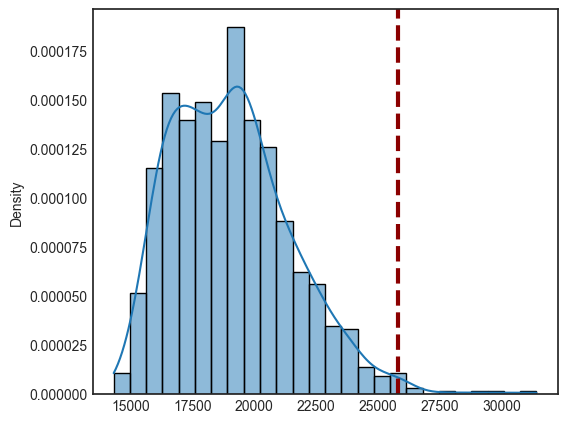

In [302]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.histplot(null_scores, stat="density", kde=True, ax=ax)
ax.axvline(obs_score, color="darkred", linestyle="--", lw=3)

pvalue = (np.sum(null_scores >= obs_score) + 1) / (len(null_scores) + 1)
print(f"p-value: {pvalue:.3g}")

## Fin